In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

In [2]:
def calculate_resource_peak(df, date_column_start='Start_Date', 
                            date_column_end='End_Date', 
                            resource_column='FTE_Required',
                            granularity='daily'):
    """
    Estimates the resource peak considering all active projects simultaneously.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns of start date, end date and required resources
    date_column_start : str
        Name of the column with start date
    date_column_end : str
        Name of the column with end date
    resource_column : str
        Name of the column with required resources (FTE)
    granularity : str
        Analysis granularity: 'daily', 'weekly', 'monthly'
    
    Returns:
    --------
    dict : Dictionary with:
        - 'peak_value': Maximum resource value
        - 'peak_date': Date of peak ocurrance
        - 'timeline': DataFrame with resources per period
    """
    import pandas as pd
    from datetime import timedelta
    
    min_date = df[date_column_start].min()
    max_date = df[date_column_end].max()
    
    if granularity == 'daily':
        freq = 'D'
    elif granularity == 'weekly':
        freq = 'W'
    elif granularity == 'monthly':
        freq = 'MS'  # Month Start
    else:
        freq = 'D'
    
    timeline = pd.date_range(start=min_date, end=max_date, freq=freq)
    resource_timeline = pd.DataFrame({'Date': timeline, 'Total_FTE': 0})
    
    for idx, row in df.iterrows():
        start = row[date_column_start]
        end = row[date_column_end]
        fte = row[resource_column]
        
        mask = (resource_timeline['Date'] >= start) & (resource_timeline['Date'] <= end)
        resource_timeline.loc[mask, 'Total_FTE'] += fte
    
    peak_idx = resource_timeline['Total_FTE'].idxmax()
    peak_value = resource_timeline.loc[peak_idx, 'Total_FTE']
    peak_date = resource_timeline.loc[peak_idx, 'Date']
    
    return {
        'peak_value': int(peak_value),
        'peak_date': peak_date,
        'timeline': resource_timeline
    }

In [ ]:
df = pd.read_csv("data/1_raw_pharma_trials_dataset.csv")

In [ ]:
df['Start_Date'].sort_values()

,Project_ID,Trial_Phase,Start_Date,End_Date,Budget,FTE_Required
0,PROJ-130,I,2020-01-03,2021-03-10,12.00,27
1,PROJ-117,II,2020-01-14,2021-08-16,28.76,30
2,PROJ-022,I,2020-01-27,2022-01-23,13.53,68
3,PROJ-108,I,2020-02-17,2021-05-22,12.92,21
4,PROJ-133,II,2020-03-20,2022-07-31,59.26,31


In [6]:
resource_peak_dict = calculate_resource_peak(df)

In [7]:
resource_peak_dict

{'peak_value': 5263,
 'peak_date': Timestamp('2023-06-13 00:00:00'),
 'timeline':            Date  Total_FTE
 0    2020-01-03         27
 1    2020-01-04         27
 2    2020-01-05         27
 3    2020-01-06         27
 4    2020-01-07         27
 ...         ...        ...
 2185 2025-12-27       3688
 2186 2025-12-28       3688
 2187 2025-12-29       3688
 2188 2025-12-30       3688
 2189 2025-12-31       3688
 
 [2190 rows x 2 columns]}

In [8]:
resource_peak_dict.keys()

dict_keys(['peak_value', 'peak_date', 'timeline'])

In [ ]:
resource_peak_dict['timeline']

,Date,Total_FTE
0,2020-01-03,27
1,2020-01-04,27
2,2020-01-05,27
3,2020-01-06,27
4,2020-01-07,27
...,...,...
2185,2025-12-27,3688
2186,2025-12-28,3688
2187,2025-12-29,3688
2188,2025-12-30,3688


In [11]:
import matplotlib.pyplot as plt

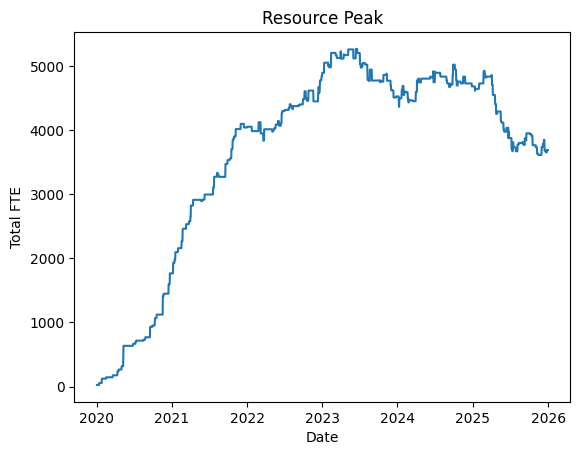

In [ ]:
plt.plot(resource_peak_dict['timeline']['Date'], resource_peak_dict['timeline']['Total_FTE'])
plt.xlabel('Date')
plt.ylabel('Total FTE')
plt.title('Resource Peak')
plt.show()

# Data partitioning

## External temporal hold-out

In [ ]:
timeline_df = resource_peak_dict['timeline'].copy()

print(timeline_df)

           Date  Total_FTE
0    2020-01-03         27
1    2020-01-04         27
2    2020-01-05         27
3    2020-01-06         27
4    2020-01-07         27
...         ...        ...
2185 2025-12-27       3688
2186 2025-12-28       3688
2187 2025-12-29       3688
2188 2025-12-30       3688
2189 2025-12-31       3688

[2190 rows x 2 columns]


In [21]:
train_size = 0.8
split_idx = int(len(timeline_df) * train_size)

train_data = timeline_df.iloc[:split_idx].copy()
test_data = timeline_df.iloc[split_idx:].copy()


print(len(timeline_df))
print(f"Train: {len(train_data)} ({len(train_data)/len(timeline_df)*100:.1f}%)")
print({train_data['Date'].min()}, {train_data['Date'].max()})
print(f"Test: {len(test_data)} ({len(test_data)/len(timeline_df)*100:.1f}%)")
print({test_data['Date'].min()}, {test_data['Date'].max()})


2190
Train: 1752 (80.0%)
{Timestamp('2020-01-03 00:00:00')} {Timestamp('2024-10-19 00:00:00')}
Test: 438 (20.0%)
{Timestamp('2024-10-20 00:00:00')} {Timestamp('2025-12-31 00:00:00')}


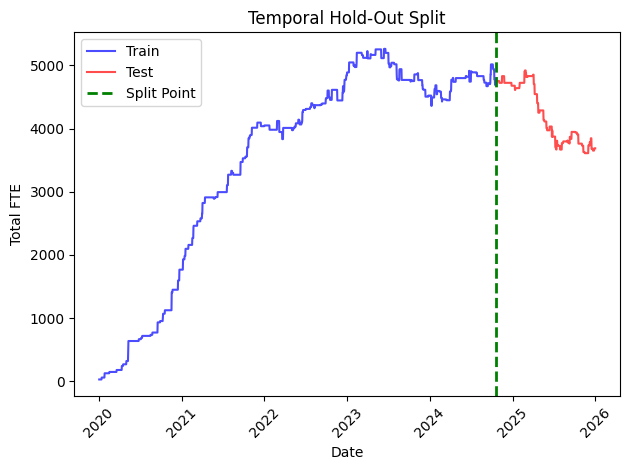

In [23]:
plt.plot(train_data['Date'], train_data['Total_FTE'], label='Train', color='blue', alpha=0.7)
plt.plot(test_data['Date'], test_data['Total_FTE'], label='Test', color='red', alpha=0.7)
plt.axvline(train_data['Date'].max(), color='green', linestyle='--', linewidth=2, label='Split Point')
plt.xlabel('Date')
plt.ylabel('Total FTE')
plt.title('Temporal Hold-Out Split')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
train_data.to_csv("data/2_train_data.csv", index=False)
test_data.to_csv("data/.test/test_data.csv", index=False)

## Internal temporal hold-out

In [27]:
internal_train_size = 0.8
split_idx = int(len(train_data) * internal_train_size)

internal_train_data = train_data.iloc[:split_idx].copy()
internal_validation_data = train_data.iloc[split_idx:].copy()


print(len(timeline_df))
print(len(train_data))
print(len(internal_train_data))
print(len(internal_validation_data))

2190
1752
1401
351


In [29]:
internal_train_data.to_csv("data/3_internal_train_data.csv", index=False)
internal_validation_data.to_csv("data/3_internal_validation_data.csv", index=False)